In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess
from datetime import datetime
from pykalman import KalmanFilter

In [2]:
#cpu_data = pd.read_csv('sysinfo.csv')
file_load = sys.argv[1]
cpu_data = pd.read_csv(file_load)

In [3]:
def to_timestamp(d):
    return d.timestamp()

In [4]:
cpu_data['timestamp_float'] = pd.to_datetime(cpu_data['timestamp']).apply(to_timestamp)

# LOESS Smoothing

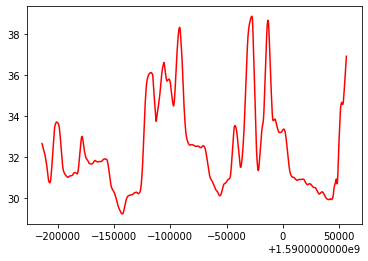

In [5]:
loess_smoothed = lowess(cpu_data['temperature'], cpu_data['timestamp_float'], frac = 0.02)

# Kalman Smoothing

In [6]:
kalman_data = cpu_data[['temperature', 'cpu_percent', 'sys_load_1', 'fan_rpm']]

temperature  cpu_percent  sys_load_1  fan_rpm
0       32.666667         4.00        0.72      797
1       32.833333         6.85        0.65      826
2       34.833333         7.71        0.85      781
3       33.000000         6.82        0.75      799
4       32.500000         8.82        0.27      785
...           ...          ...         ...      ...
4495    37.500000        13.78        4.85      944
4496    37.833333        19.93        3.60      981
4497    35.250000         5.48        3.02      896
4498    34.500000         5.52        2.41      922
4499    34.500000         3.49        2.47      860

[4500 rows x 4 columns]

In [32]:
initial_state = kalman_data.iloc[0]
observation_covariance = np.diag([0.9, 0.9, 0.9, 0.9]) ** 2 # TODO: shouldn't be zero
transition_covariance = np.diag([0.5, 0.5, 0.5, 0.5]) ** 2 # TODO: shouldn't be zero
transition = [[0.97,0.5,0.2,-0.001], [0.1,0.4,2.2,0], [0,0,0.95,0], [0,0,0,1]] # TODO: shouldn't (all) be zero

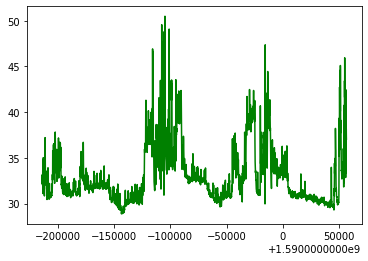

In [33]:
kf = KalmanFilter(initial_state_mean = initial_state, initial_state_covariance = observation_covariance, observation_covariance = observation_covariance, transition_covariance = transition_covariance, transition_matrices = transition)
kalman_smoothed, _ = kf.smooth(kalman_data)
plt.plot(cpu_data['timestamp_float'], kalman_smoothed[:, 0], 'g-')

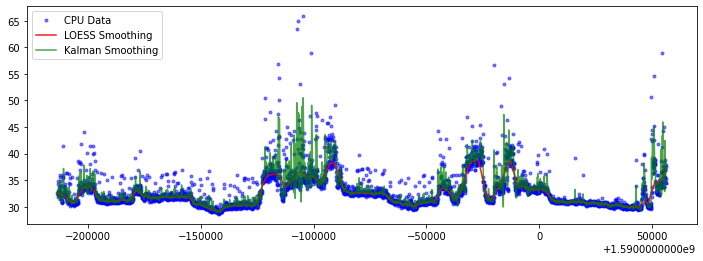

In [35]:
#ploting
plt.figure(figsize=(12, 4))
plt.plot(cpu_data['timestamp_float'], cpu_data['temperature'], 'b.', alpha=0.5)
plt.plot(cpu_data['timestamp_float'], loess_smoothed[:,1], 'r-', alpha=0.9)
plt.plot(cpu_data['timestamp_float'], kalman_smoothed[:, 0], 'g-', alpha=0.7)

plt.legend(['CPU Data', 'LOESS Smoothing', 'Kalman Smoothing'])
#plt.show() # maybe easier for testing
plt.savefig('cpu.svg') # for final submission